In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import networkx as nx

### A Look at Consumer Complaints for Financial Instituions

#### Get the financial complaints data from the Consumer Financial Protection Bureau

https://www.consumerfinance.gov/data-research/consumer-complaints/

From source:\
The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database.

In [2]:
complaints_df = pd.DataFrame()
cols = ['Date received', 
        'Product', 
        'Sub-product', 
        'Issue', 
        'Sub-issue',
        'Consumer complaint narrative', 
        'Company public response', 
        'Company', 
        'State', 
        'Date sent to company', 
        'Company response to consumer', 
        'Timely response?', 
        'Consumer disputed?']
for c in pd.read_csv('data/Consumer_Complaints.csv', chunksize = 10000, header=0, usecols=cols):
    complaints_df = complaints_df.append(c)

In [3]:
complaints_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?
0,09/20/2019,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"CCS Financial Services, Inc.",IL,09/20/2019,Closed with explanation,Yes,NaN
1,09/20/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with fraud alerts or security freezes,NaN,NaN,NaN,"ONEMAIN FINANCIAL HOLDINGS, LLC.",WA,09/20/2019,In progress,Yes,NaN
2,09/20/2019,Checking or savings account,Checking account,Managing an account,Problem accessing account,NaN,NaN,ALLY FINANCIAL INC.,CA,09/20/2019,In progress,Yes,NaN
3,09/20/2019,Debt collection,Medical debt,Attempts to collect debt not owed,Debt was result of identity theft,NaN,NaN,"Commonwealth Financial Systems, Inc.",NV,09/20/2019,Closed with explanation,Yes,NaN
4,09/20/2019,"Payday loan, title loan, or personal loan",Payday loan,Can't stop withdrawals from your bank account,NaN,NaN,NaN,"Tennessee Quick Cash, Inc.",TN,09/20/2019,In progress,Yes,NaN


In [4]:
print(str(complaints_df.iloc[-1, 0]) + ' - ' + str(complaints_df.iloc[0, 0]))

12/01/2011 - 09/20/2019


#### Get complaints from years January 1, 2012 through June 30, 2019 to match up quarterly time frames

In [5]:
complaints_df['Date received'] = pd.to_datetime(complaints_df['Date received'], format='%m/%d/%Y')
complaints_df['Date sent to company'] = pd.to_datetime(complaints_df['Date sent to company'], format='%m/%d/%Y')
complaints_df['Company'] = complaints_df['Company'].str.strip()
complaints_df_cut = complaints_df[(complaints_df['Date received'] >= pd.to_datetime('01/01/2012', format='%m/%d/%Y')) &
           (complaints_df['Date received'] <= pd.to_datetime('06/30/2019', format='%m/%d/%Y'))]
print(str(complaints_df_cut.iloc[-1, 0]) + ' - ' + str(complaints_df_cut.iloc[0, 0]))

2012-01-01 00:00:00 - 2019-06-30 00:00:00


#### Take a glance at a single example from this dataset

In [6]:
df_equifax = complaints_df_cut[complaints_df_cut['Company'] == 'EQUIFAX, INC.']
equifax_complaints = df_equifax['Date received'].value_counts()

# Aggregate by month
equifax_complaints = df_equifax.groupby(by=[df_equifax['Date received'].dt.year, 
                                            df_equifax['Date received'].dt.month])['Date received'].value_counts()
equifax_complaints = equifax_complaints.groupby([equifax_complaints.index.get_level_values(0),
                                                equifax_complaints.index.get_level_values(1)]).sum()

In [7]:
print(str(df_equifax.iloc[-1, 0]) + ' - ' + str(df_equifax.iloc[0, 0])) # Range of the data

2012-10-14 00:00:00 - 2019-06-30 00:00:00


In [8]:
equifax_complaints

Date received  Date received
2012           10                127
               11                265
               12                230
2013           1                 271
               2                 372
                                ... 
2019           2                2571
               3                3206
               4                3145
               5                3339
               6                3518
Name: Date received, Length: 81, dtype: int64

#### Plot the Equifax subset

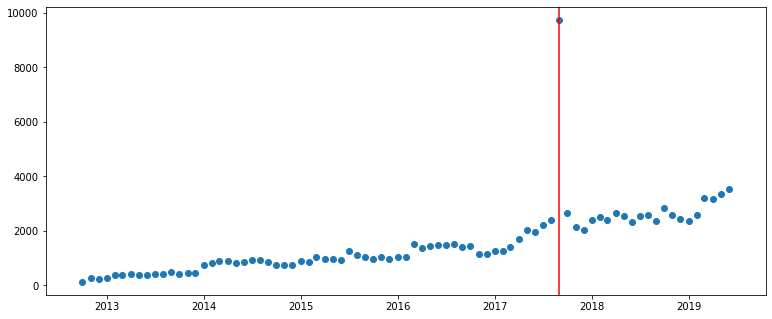

In [9]:
equifax_complaints_index = pd.to_datetime({'year': equifax_complaints.index.get_level_values(0),
                                           'month': equifax_complaints.index.get_level_values(1),
                                           'day': 1})
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.scatter(y = equifax_complaints, x = equifax_complaints_index)
ax.axvline(x=pd.to_datetime('09/01/2017', format='%m/%d/%Y'), color='r')

plt.show()

#### We can see that consumer complaints for Equifax have increased over time. There is an outlier for the month of September 2017, which coincides with the large databreach at Equifax at that time. 

#### The consumer complaints data in of itself is of limited use. We can see that unsurprisingly that large firms that service many consumers also recieve many complaints. We won't know whether they recieve a disproportionate amount unless we scale by some metric, for example the number of consumer accounts they hold.

In [10]:
# Aggregate Complaints across all years
complaints_df.groupby('Company').size().sort_values(ascending=False).head(10) 

Company
EQUIFAX, INC.                             131563
Experian Information Solutions Inc.       117384
TRANSUNION INTERMEDIATE HOLDINGS, INC.    112649
BANK OF AMERICA, NATIONAL ASSOCIATION      85179
WELLS FARGO & COMPANY                      73834
JPMORGAN CHASE & CO.                       63434
CITIBANK, N.A.                             51669
CAPITAL ONE FINANCIAL CORPORATION          37418
Navient Solutions, LLC.                    30553
OCWEN FINANCIAL CORPORATION                28371
dtype: int64

### Which Financial Institutions have the most complaints per consumer account?

#### Thankfully, we can obtain information on the number of consumer accounts for some of institutions from the FDIC

https://www.fdic.gov/bank/statistical/

In [11]:
import os
accnts_df = pd.DataFrame()
directory = 'data/transaction_accounts'
for file in os.listdir(directory):
    quarter = pd.to_datetime(file.split('_')[2], format='%Y%m%d') # Get the date info from filename
    # 'trnipcoc' corresponds to the number of accounts from 'Individuals, partnerships and corporations'
    temp_df = pd.read_csv(os.path.join(directory,file), header=0, usecols=['namehcr', 'trnipcoc'])
    temp_df = temp_df.dropna()
    temp_df['date'] = quarter
    accnts_df = accnts_df.append(temp_df)
accnts_df.columns = ['company', 'num_indiv_accnts', 'date']
accnts_df = pd.DataFrame(accnts_df.groupby(by=['date', 'company']).sum())
accnts_df = accnts_df.reset_index()
accnts_df['company'] = accnts_df['company'].str.strip()

#### Though this data set contains many of the relevant instituions, it doesn't contain all of the financial institutions from the complaints dataset

In [12]:
[l for l in accnts_df['company'] if 'Equifax' in l or 'EQUIFAX' in l]

[]

#### We need to alter the complaints data to conform  to the accounts data

In [13]:
# Reduce the complaints df to just the counts
complaints_count = complaints_df_cut[['Date received', 'Company']]
complaints_count = complaints_count.dropna()
complaints_count.columns = ['date', 'company']
# Convert to quarterly (accounts data is quarterly) counts for each company
complaints_count = complaints_count.groupby(by=[complaints_count['date'].dt.to_period('Q'), 'company'])['date'].size()
complaints_count = pd.DataFrame(complaints_count)
complaints_count.columns = ['complaints']
complaints_count = complaints_count.reset_index()
complaints_count.sort_values(by='complaints', ascending=False).head(10)

,date,company,complaints
29195,2017Q3,"EQUIFAX, INC.",14348
43308,2019Q2,"EQUIFAX, INC.",10002
44444,2019Q2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",9831
43344,2019Q2,Experian Information Solutions Inc.,9243
41388,2019Q1,"EQUIFAX, INC.",8131
41427,2019Q1,Experian Information Solutions Inc.,7848
39441,2018Q4,"EQUIFAX, INC.",7822
33311,2018Q1,Experian Information Solutions Inc.,7765
35399,2018Q2,Experian Information Solutions Inc.,7748
42449,2019Q1,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",7618


#### Similar to above, we can see that the credit reporting agencies dominate the number of complaints

#### An issue arises when on tries to simply merge the accounts data with the complaints data. Chiefly that the data for each is filed under different subsidiaries. We need a means of merging all the complaints and accounts from the subsidiaries.

#### Here's an example:

In [14]:
complaints_count[complaints_count['company'] == 'BANK OF AMERICA, NATIONAL ASSOCIATION'].head()

,date,company,complaints
22,2012Q1,"BANK OF AMERICA, NATIONAL ASSOCIATION",2885
219,2012Q2,"BANK OF AMERICA, NATIONAL ASSOCIATION",5000
469,2012Q3,"BANK OF AMERICA, NATIONAL ASSOCIATION",4441
745,2012Q4,"BANK OF AMERICA, NATIONAL ASSOCIATION",3722
1047,2013Q1,"BANK OF AMERICA, NATIONAL ASSOCIATION",5975


In [15]:
accnts_df[accnts_df['company'] == 'BANK OF AMERICA, NATIONAL ASSOCIATION'].head()

,date,company,num_indiv_accnts


In [16]:
accnts_df[accnts_df['company'] == 'BANK OF AMERICA CORPORATION'].head()

,date,company,num_indiv_accnts
321,2012-03-31,BANK OF AMERICA CORPORATION,140114965
5173,2012-06-30,BANK OF AMERICA CORPORATION,136984204
9992,2012-09-30,BANK OF AMERICA CORPORATION,147325270
14787,2012-12-31,BANK OF AMERICA CORPORATION,158349295
19518,2013-03-31,BANK OF AMERICA CORPORATION,142882000


#### The complaints for Bank of America are filed under their subsidiary "Bank of America, National Assocation", while the data regarding the number of accounts is under the parent company "Bank of America Corporation". While we could use some means of matching the company names, this is not a fool proof solution. Instead we are able to obtain information regarding the relationship of parent and subsidaries. We will use this information to link these two.

### Attributes and Relationships Data

#### Instead of matching on company name and matching text, we can use the id assigned to these instutions by the Federal Reserve. The FFIEC provides this data. 

https://www.ffiec.gov/npw/FinancialReport/DataDownload

In [17]:
attributes_df = pd.read_csv('data/CSV_ATTRIBUTES_ACTIVE.CSV', header=0, usecols=['#ID_RSSD', 'NM_LGL', 'NM_SHORT'])
attributes_df.columns = ['id', 'company', 'company_short']
attributes_df['company'] = attributes_df['company'].str.strip()
attributes_df.head()

,id,company,company_short
0,37,BANK OF HANCOCK COUNTY,BANK OF HANCOCK CTY
1,73,UTILITY EMPLOYEES FEDERAL CREDIT UNION,UTILITY EMPL FCU
2,242,FIRST COMMUNITY BANK XENIA-FLORA,FIRST CMNTY BK XENIA FLORA
3,279,"MINEOLA COMMUNITY BANK, SSB",MINEOLA CMNTY BK SSB
4,354,BISON STATE BANK,BISON ST BK


#### In addition, they provide parent and subsidiary information which we will use to match companies.

In [18]:
relationships_df = pd.read_csv('data/CSV_RELATIONSHIPS.CSV', header=0, usecols=['#ID_RSSD_PARENT', 'ID_RSSD_OFFSPRING', 'D_DT_END'])
relationships_df.columns = ['id_parent', 'id', 'end_date']
relationships_df['end_year'] = relationships_df['end_date'].str.split().apply(lambda x: x[0]).str.split('/').apply(lambda x: int(x[-1]))
relationships_df.loc[relationships_df['end_year'] == 9999, 'end_date'] = None # Make current relationship end_dates None for datetime conversion
relationships_df['end_date'] = pd.to_datetime(relationships_df['end_date'])
relationships_df.head()

,id_parent,id,end_date,end_year
0,130,1081305,1986-02-14,1986
1,279,3923155,NaT,9999
2,505,2913168,2007-06-29,2007
3,505,2913168,NaT,9999
4,505,3079566,2003-02-12,2003


#### We will now merge our prior data with this new id data

In [19]:
# Get the id's for each company
accnts_df = accnts_df.merge(attributes_df, on='company', how='left')
accnts_df = accnts_df.merge(relationships_df, on='id', how='left')

# Get the parent (na they have none) for each company
complaints_count = complaints_count.merge(attributes_df, on='company', how='left')
complaints_count = complaints_count.merge(relationships_df, on='id', how='left')

# Get ids for companies who has no parent, presently has a parent, or had a parent through the data collection date
complaints_count = complaints_count[(complaints_count['end_date'].isnull()) | (complaints_count['date'].dt.start_time < complaints_count['end_date'])]
accnts_df = accnts_df[(accnts_df['end_date'].isnull()) | (accnts_df['date'] < accnts_df['end_date'])]
accnts_df['date'] = accnts_df['date'].dt.to_period('Q') # Convert date to quarterly to reconcile with complaints

#### Now we finally merge our accounts data with our complaints data

In [20]:
parent_child_df = accnts_df.merge(complaints_count, how='outer', on=['date', 'company', 'id', 'company_short', 'id_parent', 'end_date', 'end_year'])
parent_child_df = parent_child_df.drop(['end_date', 'end_year'], axis=1)

## Sum up any company's complaints and number of accounts for each time period
# Will be used to replace duplicate company/date rows
temp_replace = pd.DataFrame(parent_child_df.groupby(by=['date', 'id'])['complaints', 'num_indiv_accnts'].sum())
## Grab the first of each company/date row
# Sort on id_parent. If there is one make it first', rest of data will be replaced
parent_child_df = parent_child_df.sort_values('id_parent').groupby(['date', 'id']).first()
# Now do the replacement
parent_child_df = parent_child_df.drop(['complaints', 'num_indiv_accnts'], axis=1).merge(temp_replace, on=['date','id'], how='inner')

In [21]:
parent_child_df.head()

company  \
date   id                                              
2012Q1 12311.0         HUNTINGTON NATIONAL BANK, THE   
       30810.0                         DISCOVER BANK   
       35570.0                        INVESTORS BANK   
       49054.0                         COMMERCE BANK   
       75633.0  BMO HARRIS BANK NATIONAL ASSOCIATION   

                                 company_short  id_parent  complaints  \
date   id                                                               
2012Q1 12311.0  HUNTINGTON NB                   1068191.0        25.0   
       30810.0  DISCOVER BK                     3846375.0       182.0   
       35570.0  INVESTORS BK                    2476869.0         2.0   
       49054.0  COMMERCE BK                     2452630.0         9.0   
       75633.0  BMO HARRIS BK NA                1245415.0        31.0   

                num_indiv_accnts  
date   id                         
2012Q1 12311.0               0.0  
       30810.0               0.0  
       35570.0               0.0  
       49054.0               0.0  
       75633.0               0.0

#### However, we still need to merge our parent and subsidiaries. First we identify all of our subsidiaries

In [22]:
child_df = parent_child_df[~parent_child_df['id_parent'].isnull()]

#### We use the relationships dataset to construct a social network of companies

In [23]:
relationships_graph = nx.from_pandas_edgelist(df=relationships_df, source='id_parent', target='id',edge_attr=['end_date'], create_using=nx.DiGraph())

In [24]:
# Use the graph of parents and subsidiaries to recurse back to the root of each subsidiary node
def get_root_nodes(node, g, passed_path = []):
    parents = list(g.predecessors(node))
    if passed_path:
        path = passed_path
    else:
        path = []
    newest_parent = None
    newest_date = pd.Timestamp(0)
    for p in parents: # Get the most current relationship
        edge_data = g.get_edge_data(p, node)
        if edge_data and pd.isna(edge_data['end_date']): # If null relationship is still active
            newest_parent = p
            newest_date = None
            break
        elif edge_data and edge_data['end_date'] > newest_date:
            newest_parent = p
            newest_date = edge_data['end_date']
    if list(filter(lambda x: newest_parent == x[0], path)): # Loop in graph
        newest_node = None
        newest_date = pd.Timestamp(0)
        for n in path:
            if pd.isna(n[1]): # Relationship is current, return this
                return n[0]
            elif n[1] > newest_date:
                newest_node = n[0]
                newest_date = n[1]
        return newest_node # Get the most recent
    else:
        path.append((newest_parent, newest_date))
    if len(parents)==0:
        return node
    else:
        return get_root_nodes(newest_parent, g, passed_path=path)

#### Verify that Bank of America, National Association (id = 480228) links to its parent company Bank of America Corporation (id = 1073757)

In [25]:
parent_child_df.loc[(slice(None), [480228, 1073757]),:].head(2)

company  \
date   id                                                 
2012Q1 480228.0   BANK OF AMERICA, NATIONAL ASSOCIATION   
       1073757.0            BANK OF AMERICA CORPORATION   

                                   company_short  id_parent  complaints  \
date   id                                                                 
2012Q1 480228.0   BANK OF AMER NA                 1199769.0      2885.0   
       1073757.0  BANK OF AMER CORP                     NaN         0.0   

                  num_indiv_accnts  
date   id                           
2012Q1 480228.0                0.0  
       1073757.0       140114965.0

In [26]:
get_root_nodes(480228, relationships_graph)

1073757

In [27]:
child_df = parent_child_df[~parent_child_df['id_parent'].isnull()]
# add_to_parent will contain the values of all the subsidiaries added together
add_to_parent = pd.DataFrame(child_df.groupby(by=['date', 'id_parent'])['complaints', 'num_indiv_accnts'].sum()) # Add these to other rows in this df
add_to_parent = add_to_parent.reset_index()
add_to_parent['id_parent'] = add_to_parent['id_parent'].apply(get_root_nodes, args=(relationships_graph,[]))
add_to_parent = add_to_parent.set_index(['date', 'id_parent'])
add_to_parent.index.names = ['date', 'id']
diff_idx = parent_child_df.index.difference(child_df.index)
parent_child_df = parent_child_df.loc[diff_idx] # drop children from df, leaving just parents

parent_child_df['complaints'] = parent_child_df['complaints'].add(add_to_parent['complaints'], fill_value=0).groupby(by=['date', 'id']).sum() # Add these to other rows in this df
parent_child_df['num_indiv_accnts'] = parent_child_df['num_indiv_accnts'].add(add_to_parent['num_indiv_accnts'], fill_value=0).groupby(by=['date', 'id']).sum()
parent_child_df = parent_child_df.drop('id_parent', axis=1)
parent_child_df = parent_child_df[(parent_child_df != 0).all(1)]

parent_child_df['complaints_per_10k'] = parent_child_df['complaints']/parent_child_df['num_indiv_accnts']*10000

#### Now we are left with a parent child dataframe with only parents

In [47]:
parent_child_df.loc[(slice(None), [480228, 1073757]),:].head(2)

,,company,company_short,complaints,num_indiv_accnts,complaints_per_10k
date,id,,,,,
2012Q1,1073757.0,BANK OF AMERICA CORPORATION,BANK OF AMER CORP,2885.0,280252928.0,0.102943
2012Q2,1073757.0,BANK OF AMERICA CORPORATION,BANK OF AMER CORP,5000.0,273990262.0,0.182488


In [30]:
top15_accnts = accnts_df.sort_values('num_indiv_accnts', ascending=False)['id'].unique()[:15]
parent_child_df.loc[('2019Q2', top15_accnts),:].sort_values('num_indiv_accnts', ascending=False)

company  \
date   id                                                    
2019Q2 1951350.0                            CITIGROUP INC.   
       1039502.0                      JPMORGAN CHASE & CO.   
       1073757.0               BANK OF AMERICA CORPORATION   
       1120754.0                     WELLS FARGO & COMPANY   
       1111435.0                  STATE STREET CORPORATION   
       3587146.0  BANK OF NEW YORK MELLON CORPORATION, THE   
       2961897.0      MITSUBISHI UFJ FINANCIAL GROUP, INC.   
       1238565.0                TORONTO-DOMINION BANK, THE   
       1069778.0   PNC FINANCIAL SERVICES GROUP, INC., THE   
       1119794.0                              U.S. BANCORP   
       1070345.0                       FIFTH THIRD BANCORP   
       1199611.0                NORTHERN TRUST CORPORATION   
       1131787.0                      SUNTRUST BANKS, INC.   

                                   company_short  complaints  \
date   id                                                      
2019Q2 1951350.0  CITIGROUP                           1969.0   
       1039502.0  JPMORGAN CHASE & CO                 2235.0   
       1073757.0  BANK OF AMER CORP                   1986.0   
       1120754.0  WELLS FARGO & CO                    2247.0   
       1111435.0  STATE STREET CORP                      1.0   
       3587146.0  BANK OF NY MELLON CORP                 8.0   
       2961897.0  MITSUBISHI UFJ FNCL GRP               39.0   
       1238565.0  TORONTO-DOMINION BK                  501.0   
       1069778.0  PNC FNCL SVC GROUP                    76.0   
       1119794.0  U S BC                               594.0   
       1070345.0  FIFTH THIRD BC                       980.0   
       1199611.0  NORTHERN TR CORP                       6.0   
       1131787.0  SUNTRUST BK                          312.0   

                  num_indiv_accnts  complaints_per_10k  
date   id                                               
2019Q2 1951350.0       455318142.0            0.043244  
       1039502.0       290455000.0            0.076948  
       1073757.0       234115000.0            0.084830  
       1120754.0       105938006.0            0.212105  
       1111435.0        65277000.0            0.000153  
       3587146.0        63395093.0            0.001262  
       2961897.0        48330114.0            0.008070  
       1238565.0        44261956.0            0.113190  
       1069778.0        39497986.0            0.019241  
       1119794.0        34297556.0            0.173190  
       1070345.0        16884924.0            0.580399  
       1199611.0        14089146.0            0.004259  
       1131787.0        13974680.0            0.223261

#### A problem with this naive summing of the subsidiary companies is the potential for double counting customers. We can see for the second quarer of 2019 the four largest banks each have roughly the same number of complaints, yet their number of accounts varies considerably. Other methods would need to be pursued in order to ensure that this issue is minimized. Further, it is unclear how translatable the complaints of a subsidiary apply to the parent. In the case of Bank of America Corporation and Bank of America, National Association a close assocation might be clear; however, ascribing all the complaints from varied subsidiaries to the parent might not be appropriate, especially in the case of distict differences in the operation of the subsidary or in the organizational and management structures. Suffice to say that this analysis becomes less effectual as the complexity and differences between subsidary and parent increase and is at its best when investigating companies with few subsidaries and with little differences between their operation.  

In [145]:
top15_complaints = parent_child_df.sort_values('complaints_per_10k', ascending=False)
top15_complaints = top15_complaints[(top15_complaints['num_indiv_accnts']>100000) & 
                                    (top15_complaints['complaints']>100)]
top15_complaints_idx = top15_complaints.index.get_level_values(1).unique()[:15]
top15_complaints = top15_complaints.loc[(slice(None),top15_complaints_idx),:].sort_index()

replace_name_dict = {}
for name, name_short in zip(top15_complaints['company'].unique(), top15_complaints['company_short'].unique()) :
    name_spl = name.strip().split()
    if len(name_spl)<=3:
        replace_name = ' '.join(name_spl).title()
    else:
        replace_name = ' '.join(name_spl[:2]).title()
    replace_name_dict[name_short] = replace_name
top15_complaints = top15_complaints.replace({'company_short': replace_name_dict})
top15_complaints.tail()

company  \
date   id                                                  
2019Q2 1391237.0   BANCO BILBAO VIZCAYA ARGENTARIA, S.A.   
       1447376.0  UNITED SERVICES AUTOMOBILE ASSOCIATION   
       1562859.0                     ALLY FINANCIAL INC.   
       3846375.0             DISCOVER FINANCIAL SERVICES   
       4224000.0                         MP (THRIFT) LLC   

                                company_short  complaints  num_indiv_accnts  \
date   id                                                                     
2019Q2 1391237.0                 Banco Bilbao       181.0         3196194.0   
       1447376.0              United Services       347.0         9213533.0   
       1562859.0          Ally Financial Inc.       284.0         3669000.0   
       3846375.0  Discover Financial Services       539.0          876365.0   
       4224000.0              Mp (Thrift) Llc       109.0         1118598.0   

                  complaints_per_10k  
date   id                             
2019Q2 1391237.0            0.566299  
       1447376.0            0.376620  
       1562859.0            0.774053  
       3846375.0            6.150405  
       4224000.0            0.974434

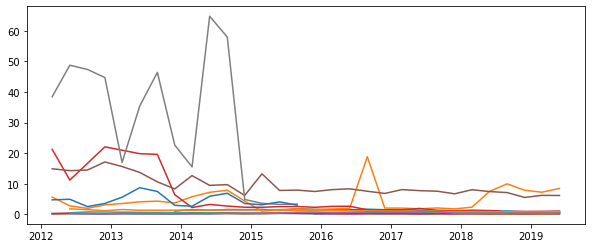

In [142]:
fig, ax = plt.subplots(figsize=(10,4))

for n, group in top15_complaints.groupby('company_short'):
    complaints_index = pd.to_datetime({'year': group.index.get_level_values(0).year,
                                       'month': group.index.get_level_values(0).month,
                                       'day': 1}).unique()
    plt.plot(complaints_index, group['complaints_per_10k'])
